This notebook contains plots of various statistical and systems metrics gathered from the last run

In [415]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import visualization_utils

In [416]:
"""dict: Model specific parameter specification"""

ACCURACY_KEY = 'accuracy'
BYTES_WRITTEN_KEY = 'bytes_written'
BYTES_READ_KEY = 'bytes_read'
LOCAL_COMPUTATIONS_KEY = 'local_computations'
NUM_ROUND_KEY = 'round_number'
NUM_SAMPLES_KEY = 'num_samples'
CLIENT_ID_KEY = 'client_id'

In [417]:
"""Helper to visualize metrics."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from decimal import Decimal

# models_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(models_dir)


def _set_plot_properties(properties):
    """Sets some plt properties."""
    if 'xlim' in properties:
        plt.xlim(properties['xlim'])
    if 'ylim' in properties:
        plt.ylim(properties['ylim'])
    if 'xlabel' in properties:
        plt.xlabel(properties['xlabel'])
    if 'ylabel' in properties:
        plt.ylabel(properties['ylabel'])


def plot_accuracy_vs_round_number(stat_metrics, weighted=False, plot_stds=False,
        figsize=(4, 3), title_fontsize=16, **kwargs):
    """Plots the clients' average test accuracy vs. the round number.

    Args:
        stat_metrics: pd.DataFrame as written by writer.py.
        weighted: Whether the average across clients should be weighted by number of
            test samples.
        plot_stds: Whether to plot error bars corresponding to the std between users.
        figsize: Size of the plot as specified by plt.figure().
        title_fontsize: Font size for the plot's title.
        kwargs: Arguments to be passed to _set_plot_properties."""
    plt.figure(figsize=figsize)
    title_weighted = 'Weighted' if weighted else 'Unweighted'
    # plt.title('Accuracy vs Round Number (%s)' % title_weighted, fontsize=title_fontsize)
    if weighted:
        accuracies = stat_metrics.groupby(NUM_ROUND_KEY).apply(_weighted_mean, ACCURACY_KEY, NUM_SAMPLES_KEY)
        accuracies = accuracies.reset_index(name=ACCURACY_KEY)

        stds = stat_metrics.groupby(NUM_ROUND_KEY).apply(_weighted_std, ACCURACY_KEY, NUM_SAMPLES_KEY)
        stds = stds.reset_index(name=ACCURACY_KEY)
    else:
        accuracies = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).mean()
        stds = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).std()

    if plot_stds:
        plt.errorbar(accuracies[NUM_ROUND_KEY], accuracies[ACCURACY_KEY], stds[ACCURACY_KEY])
    else:
        plt.plot(accuracies[NUM_ROUND_KEY], accuracies[ACCURACY_KEY])

    percentile_10 = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).quantile(0.1)
    percentile_90 = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).quantile(0.9)

    plt.plot(percentile_10[NUM_ROUND_KEY], percentile_10[ACCURACY_KEY], linestyle=':')
    plt.plot(percentile_90[NUM_ROUND_KEY], percentile_90[ACCURACY_KEY], linestyle=':')

    # plt.legend(['Mean', '10th percentile', '90th percentile'], loc='upper left')

    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Round Number', fontsize=14)
    plt.yticks(fontsize=12)  # Increase x-axis tick font size
    plt.xticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    _set_plot_properties(kwargs)
    plt.savefig("../results/images/reddit/accuracy-vs-rounds-promethee.png")
    plt.show()


def _weighted_mean(df, metric_name, weight_name):
    d = df[metric_name]
    w = df[weight_name]
    try:
        return (w * d).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan


def _weighted_std(df, metric_name, weight_name):
    d = df[metric_name]
    w = df[weight_name]
    try:
        weigthed_mean = (w * d).sum() / w.sum()
        return (w * ((d - weigthed_mean) ** 2)).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan


def plot_accuracy_vs_round_number_per_client(
        stat_metrics, sys_metrics, max_num_clients, figsize=(25, 15), title_fontsize=16, max_name_len=10, **kwargs):
    """Plots the clients' test accuracy vs. the round number.

    Args:
        stat_metrics: pd.DataFrame as written by writer.py.
        sys_metrics: pd.DataFrame as written by writer.py. Allows us to know which client actually performed training
            in each round. If None, then no indication is given of when was each client trained.
        max_num_clients: Maximum number of clients to plot.
        figsize: Size of the plot as specified by plt.figure().
        title_fontsize: Font size for the plot's title.
        max_name_len: Maximum length for a client's id.
        kwargs: Arguments to be passed to _set_plot_properties."""
    # Plot accuracies per client.
    clients = stat_metrics[CLIENT_ID_KEY].unique()[:max_num_clients]
    cmap = plt.get_cmap('jet_r')
    plt.figure(figsize=figsize)

    for i, c in enumerate(clients):
        color = cmap(float(i) / len(clients))
        c_accuracies = stat_metrics.loc[stat_metrics[CLIENT_ID_KEY] == c]
        plt.plot(c_accuracies[NUM_ROUND_KEY], c_accuracies[ACCURACY_KEY], color=color)

    # plt.suptitle('Accuracy vs Round Number (Per Client)', fontsize=title_fontsize)
    # plt.title('(Dots indicate that client was trained at that round)')
    plt.xlabel('Round Number', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

    labels = stat_metrics[[CLIENT_ID_KEY, NUM_SAMPLES_KEY]].drop_duplicates()
    labels = labels.loc[labels[CLIENT_ID_KEY].isin(clients)]
    labels = ['%s, %d' % (row[CLIENT_ID_KEY][:max_name_len], row[NUM_SAMPLES_KEY])
              for _, row in labels.iterrows()]
    # plt.legend(labels, title='client id, num_samples', loc='center left', bbox_to_anchor=(1, 0.5))

    # Plot moments in which the clients were actually used for training.
    # To do this, we need the system metrics (to know which client actually performed training in each round).
    if sys_metrics is not None:
        for i, c in enumerate(clients[:max_num_clients]):
            color = cmap(float(i) / len(clients))
            c_accuracies = stat_metrics.loc[stat_metrics[CLIENT_ID_KEY] == c]
            c_computation = sys_metrics.loc[sys_metrics[CLIENT_ID_KEY] == c]
            c_join = pd.merge(c_accuracies, c_computation, on=NUM_ROUND_KEY, how='inner')
            if not c_join.empty:
                plt.plot(
                    c_join[NUM_ROUND_KEY],
                    c_join[ACCURACY_KEY],
                    linestyle='None',
                    marker='.',
                    color=color,
                    markersize=18)

    _set_plot_properties(kwargs)
    plt.savefig("../results/images/reddit/accuracy-vs-rounds-per-client-promethee.png")
    plt.show()


def plot_bytes_written_and_read(sys_metrics, rolling_window=10, figsize=(4, 3), title_fontsize=16, **kwargs):
    """Plots the cumulative sum of the bytes written and read by the server.

    Args:
        sys_metrics: pd.DataFrame as written by writer.py.
        rolling_window: Number of previous rounds to consider in the cumulative sum.
        figsize: Size of the plot as specified by plt.figure().
        title_fontsize: Font size for the plot's title.
        kwargs: Arguments to be passed to _set_plot_properties."""

    plt.figure(figsize=figsize)

    server_metrics = sys_metrics.groupby(NUM_ROUND_KEY, as_index=False).sum()
    rounds = server_metrics[NUM_ROUND_KEY]
    server_metrics = server_metrics.rolling(rolling_window, on=NUM_ROUND_KEY, min_periods=1).sum()
    plt.plot(rounds, server_metrics['bytes_written'], alpha=0.7)
    plt.plot(rounds, server_metrics['bytes_read'], alpha=0.7)

    # plt.title('Bytes Written and Read by Server vs. Round Number', fontsize=title_fontsize)
    plt.xlabel('Round Number', fontsize=14)
    plt.ylabel('Bytes', fontsize=14)
    plt.grid(True)
    # plt.legend(['Bytes Written', 'Bytes Read'], loc='upper right')
    _set_plot_properties(kwargs)
    plt.savefig("../results/images/reddit/bytes-exchanged-promethee.png")
    plt.show()


def plot_client_computations_vs_round_number(
        sys_metrics,
        aggregate_window=20,
        max_num_clients=20,
        figsize=(15, 6),
        title_fontsize=16,
        max_name_len=10,
        range_rounds=None):
    """Plots the clients' local computations against round number.

    Args:
        sys_metrics: pd.DataFrame as written by writer.py.
        aggregate_window: Number of rounds that are aggregated. e.g. If set to 20, then
            rounds 0-19, 20-39, etc. will be added together.
        max_num_clients: Maximum number of clients to plot.
        figsize: Size of the plot as specified by plt.figure().
        title_fontsize: Font size for the plot's title.
        max_name_len: Maximum length for a client's id.
        range_rounds: Tuple representing the range of rounds to be plotted. The rounds
            are subsampled before aggregation. If None, all rounds are considered."""
    plt.figure(figsize=figsize)

    num_rounds = sys_metrics[NUM_ROUND_KEY].max()
    clients = sys_metrics[CLIENT_ID_KEY].unique()[:max_num_clients]

    comp_matrix = []
    matrix_keys = [f'client {i+1}' for i in range(max_num_clients)]

    for c in clients:
        client_rows = sys_metrics.loc[sys_metrics[CLIENT_ID_KEY] == c]
        client_rows = client_rows.groupby(NUM_ROUND_KEY, as_index=False).sum()
        client_computations = [0 for _ in range(num_rounds)]

        for i in range(num_rounds):
            computation_row = client_rows.loc[client_rows[NUM_ROUND_KEY] == i]
            if not computation_row.empty:
                client_computations[i] = computation_row.iloc[0][LOCAL_COMPUTATIONS_KEY]
        comp_matrix.append(client_computations)

    if range_rounds:
        assert range_rounds[0] >= 0 and range_rounds[1] > 0
        assert range_rounds[0] <= range_rounds[1]
        assert range_rounds[0] < len(comp_matrix[0]) and range_rounds[1] < len(comp_matrix[0]) + 1
        assert range_rounds[1] - range_rounds[0] >= aggregate_window
        new_comp_matrix = []
        for i in range(len(comp_matrix)):
            new_comp_matrix.append(comp_matrix[i][range_rounds[0]:range_rounds[1]])
        comp_matrix = new_comp_matrix

    agg_comp_matrix = []
    for c_comp_vals in comp_matrix:
        num_rounds = len(c_comp_vals)
        agg_c_comp_vals = []
        for i in range(num_rounds // aggregate_window):
            agg_c_comp_vals.append(
                np.sum(c_comp_vals[i * aggregate_window:(i + 1) * aggregate_window]))
        agg_comp_matrix.append(agg_c_comp_vals)

    # plt.title(
    #     'Total Client Computations (FLOPs) vs. Round Number (x %d)' % aggregate_window,
    #     fontsize=title_fontsize)
    im = plt.imshow(agg_comp_matrix)
    plt.yticks(range(len(matrix_keys)), matrix_keys, fontsize=12)
    plt.colorbar(im, fraction=0.02, pad=0.01)
    plt.savefig("../results/images/reddit/client-computation-vs-rounds-promethee.png")
    plt.show()


def get_longest_flops_path(sys_metrics):
    """Prints the largest amount of flops required to complete training.

    To calculate this metric, we:
        1. For each round, pick the client that required the largest amount
            of local training.
        2. Sum the FLOPS from the clients picked in step 1 across rounds.

    TODO: This metric would make more sense with seconds instead of FLOPS.

    Args:
        sys_metrics: pd.DataFrame as written by writer.py."""
    num_rounds = sys_metrics[NUM_ROUND_KEY].max()
    clients = sys_metrics[CLIENT_ID_KEY].unique()

    comp_matrix = []

    for c in clients:
        client_rows = sys_metrics.loc[sys_metrics[CLIENT_ID_KEY] == c]
        client_rows = client_rows.groupby(NUM_ROUND_KEY, as_index=False).sum()
        client_computations = [0 for _ in range(num_rounds)]

        for i in range(num_rounds):
            computation_row = client_rows.loc[client_rows[NUM_ROUND_KEY] == i]
            if not computation_row.empty:
                client_computations[i] = computation_row.iloc[0][LOCAL_COMPUTATIONS_KEY]
        comp_matrix.append(client_computations)

    comp_matrix = np.asarray(comp_matrix)
    num_flops = np.sum(np.max(comp_matrix, axis=0))
    return '%.2E' % Decimal(num_flops.item())

In [418]:
def load_data(stat_metrics_file=None, sys_metrics_file=None):
    """Loads the data from the given stat_metric and sys_metric files."""
    stat_metrics = pd.read_csv(stat_metrics_file) if stat_metrics_file else None
    if sys_metrics_file:
        # Define the columns based on the data structure you have mentioned
        sys_columns = [
            'client_id', 'round_number', 'hierarchy', 'num_samples', 'set',
            'bytes_read', 'bytes_written', 'local_computations'
        ]
        sys_metrics = pd.read_csv(sys_metrics_file, header=None, names=sys_columns)
        sys_metrics.sort_values(by='round_number', inplace=True)
    else:
        sys_metrics = None
#     sys_metrics = pd.read_csv(sys_metrics_file) if sys_metrics_file else None

    print(stat_metrics.head())
    print(sys_metrics.head())
    
    print("\nColumn names in the dataframe:")
    print("stat_metrics", stat_metrics.columns)
    print("sys_metrics", sys_metrics.columns)

    if stat_metrics is not None:
        stat_metrics.sort_values(by=NUM_ROUND_KEY, inplace=True)
    if sys_metrics is not None:
        sys_metrics.sort_values(by=NUM_ROUND_KEY, inplace=True)

    return stat_metrics, sys_metrics

In [419]:
SHOW_WEIGHTED = True # show weighted accuracy instead of unweighted accuracy
PLOT_CLIENTS = False
stat_file = 'reddit/reddit_experiment_promethee_stat.csv' # change to None if desired
sys_file = 'reddit/reddit_experiment_promethee_sys.csv' # change to None if desired

stat_metrics, sys_metrics = load_data(stat_file, sys_file)

   client_id  round_number  hierarchy  num_samples   set  accuracy      loss
0      10069             0        NaN            8  test       0.0  9.195742
1      10085             0        NaN           11  test       0.0  9.200913
2      10255             0        NaN           10  test       0.0  8.060468
3      10262             0        NaN           76  test       0.0  9.205132
4        104             0        NaN            8  test       0.0  7.384616
     client_id  round_number  hierarchy  num_samples    set  bytes_read  \
0         6092             1        NaN           21  train    24722496   
916      67160             1        NaN          199  train    24722496   
915      48240             1        NaN           59  train    24722496   
914      39295             1        NaN           40  train    24722496   
913      77690             1        NaN           29  train    24722496   

     bytes_written  local_computations  
0         24722496          1255067055  
916  

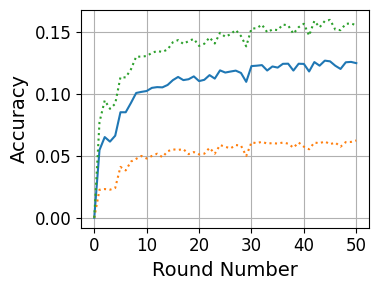

In [420]:
# Plots accuracy vs. round number.
if stat_metrics is not None:
    plot_accuracy_vs_round_number(stat_metrics, True, plot_stds=False)

In [421]:
if PLOT_CLIENTS and stat_metrics is not None:
    plot_accuracy_vs_round_number_per_client(stat_metrics, sys_metrics, max_num_clients=20)

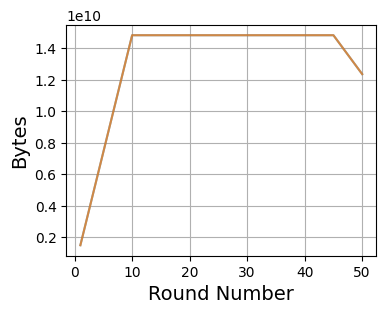

In [422]:
# Plots the cumulative sum of the bytes written and read by the server in 
# the past rolling_window rounds versus the round number

if stat_metrics is not None:
    plot_bytes_written_and_read(sys_metrics, rolling_window=10)

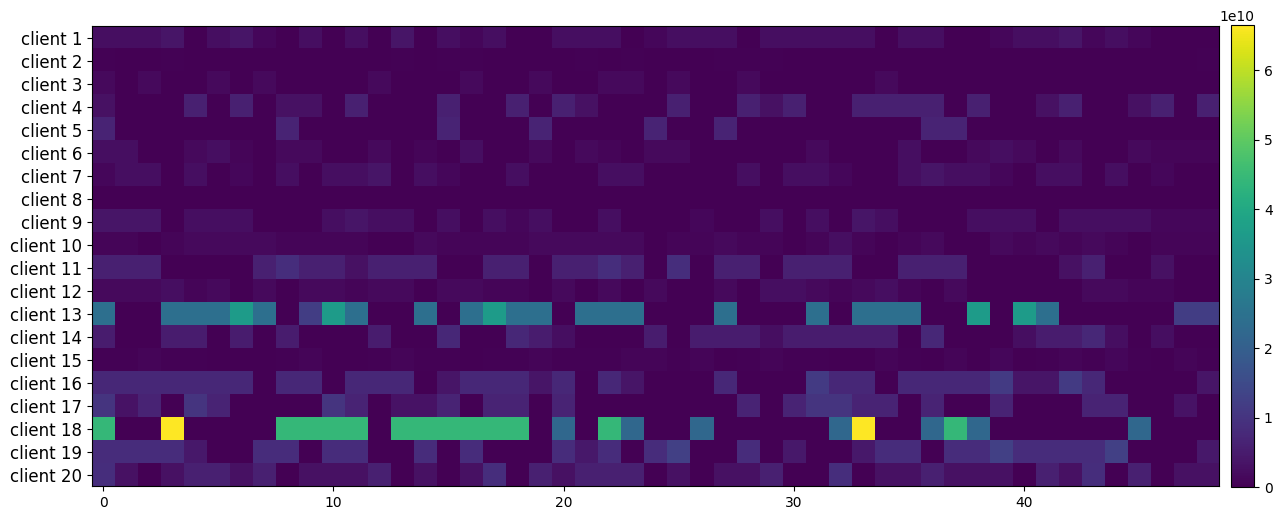

In [423]:
plot_client_computations_vs_round_number(sys_metrics, aggregate_window=1, max_num_clients=20, range_rounds=(1, 50))

In [424]:
print('Longest FLOPs path: %s' % visualization_utils.get_longest_flops_path(sys_metrics))

Longest FLOPs path: 2.66E+12
